In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import random
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import re
import math

class MyDataset(Dataset):
    def __init__(self,dataset): 
        self.data = dataset
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.data[index][1]
        return x, y
    
def preprocess(token):
    if token.find('://') != -1:
        token = '@@URL'
    elif re.match('^\d+([,.]\d+)*$', token):
        token = '@@DIGIT'
    elif re.match('^\d{1,2}:\d{2}$', token):
        token = '@@TIME'
    elif re.match('^\d+/\d+(/\d+)?$', token):
        token = '@@DATE'
    else:
        token = str.lower(token)
    return token

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.fillna('<unknown>', inplace=True)
test.fillna('<unknown>', inplace=True)
train_df, val_df = train_test_split(train, test_size=0.1, train_size=None, shuffle=True)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 100)
tokenizer = TweetTokenizer()

device = 'cuda:5'

In [2]:
min_wordcount = 10
min_kwcount = 10
min_loccount = 10

counter = {}
for text in train_df.text:
    for token in tokenizer.tokenize(text):
        token = preprocess(token)
        counter[token] = counter.get(token, 0) + 1

df = pd.DataFrame(list(counter.items()), columns=['word', 'count'])
stop_words = df[df['count']<=min_wordcount].word.tolist()
vocab = df[df['count']>min_wordcount].word.tolist()



le_kw = preprocessing.LabelEncoder().fit(train_df.keyword.tolist())
le_loc = preprocessing.LabelEncoder().fit(train_df.location.tolist())
loc = train_df.groupby('location').count().rename({'id':'cnt'}, axis=1)[['cnt']]
kw = train_df.groupby('keyword').count().rename({'id':'cnt'}, axis=1)[['cnt']]
loc = loc[loc['cnt']>min_loccount].index.tolist()
kw = kw[kw['cnt']>min_kwcount].index.tolist()

le = preprocessing.LabelEncoder().fit(vocab)
le.classes_ = np.append(le.classes_, '<unknown>')
le.classes_ = np.append(le.classes_, '<pad>')
le.classes_ = np.append(le.classes_, '<begin>')
le.classes_ = np.append(le.classes_, '<end>')
le_loc = preprocessing.LabelEncoder().fit(loc)
le_kw = preprocessing.LabelEncoder().fit(kw)

In [4]:
def create_dataset(df, MAX_LENGTH=53, le=le, le_kw=le_kw, le_loc=le_loc):
    data = []
    txt = []
    loc = []
    kw = []
    tg = []
    
    for i in df.itertuples():
        text = i[4]
        l = i[3]
        k = i[2]
        tokens = ['<begin>']
        for token in tokenizer.tokenize(text):
            token = preprocess(token)
            if token in vocab:
                tokens.append(token)
            else:
                tokens.append('<unknown>')
        if len(tokens) > MAX_LENGTH:
            continue
        elif len(tokens) < MAX_LENGTH:
            tokens += ['<pad>'] * (MAX_LENGTH-len(tokens))
        tokens += ['<end>']
            
        x = le.transform(np.array(tokens))
        txt.append(x)
        
        if l in le_loc.classes_:
            loc.append(l)
        else:
            loc.append('<unknown>')

        if k in le_kw.classes_:
            kw.append(k)
        else:
            kw.append('<unknown>')
            
        tg.append(i[5])
            
    kw = le_kw.transform(kw)
    loc = le_loc.transform(loc)

    for i in range(len(txt)):
        data.append(((torch.tensor(txt[i]).long().to(device),
                     torch.tensor(kw[i]).long().to(device), torch.tensor(loc[i]).long().to(device)),\
                     torch.tensor(tg[i]).to(device)))
    return data

train_dataset = MyDataset(create_dataset(train_df))
val_dataset = MyDataset(create_dataset(val_df))

In [39]:
BATCH_SIZE = 64
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

def validate(model):
    model.eval()
    running_loss = 0
    right = 0
    total = 0
    with torch.no_grad():
        for it, (batch_x, batch_y) in enumerate(val_loader):
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            running_loss += loss.item()
            top_n, top_i = logits.topk(1)
            right += (top_i[:,0] == batch_y).sum()
            total += batch_y.shape[0]
        print('validation loss:', running_loss/len(val_loader))
        print('validation accuracy:', float(right/total))
        
    return running_loss/len(val_loader)

In [27]:
class Model(nn.Module):
    def __init__(self, hid_feats):
        super().__init__()
        
        self.embed_word = nn.Embedding(len(le.classes_), hid_feats)
        self.embed_kw = nn.Embedding(len(le_kw.classes_), 32)
        self.embed_loc = nn.Embedding(len(le_loc.classes_), 6)
        
        self.gru = nn.GRU(hid_feats, hid_feats, bidirectional=False, batch_first=True)
        
        #self.linear0 = nn.Linear(hid_feats*2, hid_feats)
        self.linear1 = nn.Linear(hid_feats+38, hid_feats)
        self.linear2 = nn.Linear(hid_feats, 2)
        
    def forward(self, inputs):
        seq = self.embed_word(inputs[0])
        kw = self.embed_kw(inputs[1])
        loc = self.embed_loc(inputs[2])
        seq = self.gru(seq)[0][:, -1, :]
        #seq = self.linear0(seq)
        
        output = F.leaky_relu(self.linear1(torch.cat([kw, loc, seq], 1)))
#         output = seq+loc+kw
        output = self.linear2(output)
        return output

epoch: 0
training loss: 0.815525587529344
validation loss: 0.6292819082736969
validation accuracy: 0.6614173054695129
epoch: 1
training loss: 0.7854819461368948
validation loss: 0.5827739238739014
validation accuracy: 0.7034120559692383
epoch: 2
training loss: 0.7614853127207151
validation loss: 0.5510751754045486
validation accuracy: 0.7139107584953308
epoch: 3
training loss: 0.7448308552033343
validation loss: 0.5332398563623428
validation accuracy: 0.7335957884788513
epoch: 4
training loss: 0.7364372721922935
validation loss: 0.5219400301575661
validation accuracy: 0.7362204790115356
epoch: 5
training loss: 0.7280533080930691
validation loss: 0.5186899428566297
validation accuracy: 0.7401574850082397
epoch: 6
training loss: 0.7249184440866613
validation loss: 0.5215530147155126
validation accuracy: 0.73884516954422
epoch: 7
training loss: 0.7230343575064533
validation loss: 0.5153836334745089
validation accuracy: 0.7427821755409241
epoch: 8
training loss: 0.7278437684445124
validati

<AxesSubplot:>

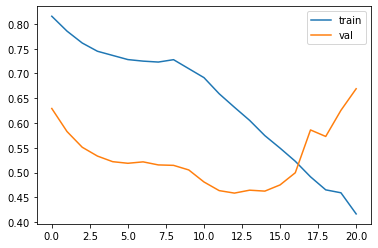

In [40]:
model = Model(hid_feats=50).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-3)
criterion = nn.CrossEntropyLoss()
te = []
val = []
tr = []

for epoch in range(21):
    print('epoch:', epoch)
    model.train()
    running_loss = 0
    for it, (batch_x, batch_y) in enumerate(train_loader):
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        running_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    print('training loss:', math.sqrt(running_loss/len(train_loader)))
    tr.append(math.sqrt(running_loss/len(train_loader)))
    
    if True:
        val.append(validate(model))


loss_df = pd.DataFrame({'train':tr, 'val':val})
loss_df.plot()

In [35]:
pred = []
label = []
with torch.no_grad():
    for it, (batch_x, batch_y) in enumerate(val_loader):
        logits = model(batch_x)
        
        top_n, top_i = logits.topk(1)
        pred += top_i[:,0].cpu().numpy().tolist()
        label += batch_y.cpu().numpy().tolist()
result_df = pd.DataFrame({'pred':pred, 'label':label})

In [36]:
result_df

,pred,label
0,1,1
1,1,1
2,1,1
3,1,1
4,0,0
...,...,...
757,0,0
758,0,0
759,1,1
760,0,0
